In [2]:
import os
import json
import gc
import cv2
import keras
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import concatenate, Input
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import multi_gpu_model
import numpy as np
import pandas as pd
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Preprocessing

In [2]:
train_df = pd.read_csv('../input/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

In [3]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]

## Utility Functions

In [14]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

## Data Generator

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

In [16]:
BATCH_SIZE = 16

train = np.array(non_missing_train_idx.index)

np.random.shuffle(train)
train_num = int(len(train)*0.95)
train_idx = train[:train_num]
val_idx = train[train_num:]

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

## Model

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [40]:
def build_model(input_shape):
    num_classes = 4
    width = 8
    def conv_block(x, width, k_reg=False):
        c1 = Conv2D(width, (3, 3), activation='relu', padding='same') (x)
        c1 = Conv2D(width, (3, 3), activation='relu', padding='same') (c1)
        return c1

    inputs = Input(input_shape)
    activation = 'sigmoid'
    c1 = conv_block(inputs, width)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv_block(p1, width*2, k_reg=True)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv_block(p2, width*4, k_reg=True)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv_block(p3, width*8, k_reg=True)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv_block(p4, width*16)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
    
    cm = conv_block(p5, width*8)
    m1 = Conv2D(width*8, (3, 3), activation='relu', dilation_rate = 2, padding='same') (cm)
    m2 = Conv2D(width*8, (3, 3), activation='relu', dilation_rate = 4, padding='same') (m1)
    m3 = Conv2D(width*8, (3, 3), activation='relu', dilation_rate = 8, padding='same') (m2)
    m4 = Conv2D(width*8, (3, 3), activation='relu', dilation_rate = 16, padding='same') (m2)
    cm = concatenate([cm, m1, m2, m3, m4])
    
    um = Conv2DTranspose(width*16, (2, 2), strides=(2, 2), padding='same') (cm)
    um = concatenate([um, c5])
    cm = conv_block(um, width*16)

    u6 = Conv2DTranspose(width*8, (2, 2), strides=(2, 2), padding='same') (cm)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, width*8)

    u7 = Conv2DTranspose(width*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, width*4)

    u8 = Conv2DTranspose(width*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, width*2)

    u9 = Conv2DTranspose(width, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv_block(u9, width)

    outputs = Conv2D(num_classes, (1, 1), activation=activation) (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [41]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_214 (Conv2D)             (None, 256, 1600, 8) 80          input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_215 (Conv2D)             (None, 256, 1600, 8) 584         conv2d_214[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_215[0][0]                 
____________________________________________________________________________________________

In [42]:
#/model = multi_gpu_model(model, gpus=4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
checkpoint = ModelCheckpoint(
    'base_UNET_MCAD.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=20
)

# if the model learns, then add function for context module

## Evaluation

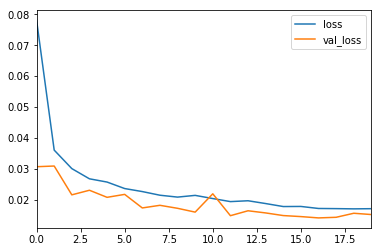

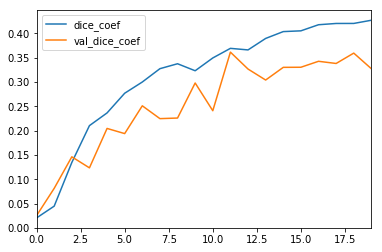

In [44]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [45]:
history_df.to_csv('history/base_UNET_MCAD_history.csv')

## Visualize

In [ ]:
test = val_generator.__getitem__(6)
print(len(test), test[0].shape, test[1].shape)
plt.imshow(np.squeeze(test[0][0])); plt.show()
plt.imshow(test[1][0][...,0]); plt.show()
plt.imshow(test[1][0][...,1]); plt.show()
plt.imshow(test[1][0][...,2]); plt.show()
plt.imshow(test[1][0][...,3])

In [ ]:
test_pred = np.squeeze(model.predict(np.expand_dims(test[0][0], axis=0)))
plt.imshow(np.squeeze(test_pred)[...,0]); plt.show()
plt.imshow(np.squeeze(test_pred)[...,1]); plt.show()
plt.imshow(np.squeeze(test_pred)[...,2]); plt.show()
plt.imshow(np.squeeze(test_pred)[...,3])

In [9]:
def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 256))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
BATCH_SIZE = 64
model = load_model('base_UNET_MCAD.h5', custom_objects={'dice_coef': dice_coef})
sub_df = pd.read_csv('../input/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
test_imgs.head()

In [15]:
test_generator = DataGenerator(test_imgs.index, df=test_imgs, shuffle=False, mode='predict', target_df=test_imgs,
        base_path='../input/test_images',
        batch_size=BATCH_SIZE,
        n_classes=4
    )
test_df = []

for i in range(0, test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(batch_idx, df=test_imgs, shuffle=False,mode='predict',base_path='../input/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
    gc.collect()

300/300 [==============================] - 4s 15ms/step


300it [00:04, 69.19it/s]


300/300 [==============================] - 5s 16ms/step


300it [00:04, 67.45it/s]


300/300 [==============================] - 5s 16ms/step


300it [00:04, 67.04it/s]


300/300 [==============================] - 5s 16ms/step


300it [00:04, 68.64it/s]


300/300 [==============================] - 5s 15ms/step


300it [00:04, 67.09it/s]


300/300 [==============================] - 5s 15ms/step


300it [00:04, 69.75it/s]


1/1 [==============================] - 0s 25ms/step


1it [00:00, 57.74it/s]


In [16]:
test_df = pd.concat(test_df)
print(test_df.shape)
test_df.head()

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,,004f40c73.jpg
1,004f40c73.jpg_2,,004f40c73.jpg
2,004f40c73.jpg_3,,004f40c73.jpg
3,004f40c73.jpg_4,,004f40c73.jpg
4,006f39c41.jpg_1,,006f39c41.jpg


In [17]:
test_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('submission.csv', index=False)